# What makes a game succeed?

In this project, I will observe numerous factors, including user reviews, expert reviews, genres, platforms, and historical game sales, to identify patterns that historically cause games to succeed or fail after their launch. 

To accomplish this, I will first observe and preprocess/clean the data. Once the data has been cleaned, I can begin to analyze the data. I will check the number of games released in a year and across platforms, figure out which platforms and years of release are relevant for our analysis, and look at global and regional sales across a multitude of factors, including user reviews and genres. Finally, I will conduct hypothesis testing to observe how average user ratings change across genres and platforms.

## Initialization

I will start by loading in the required libraries and loading in the data from the csv file.

In [1]:
# loading required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# load data
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    print("Invalid file path.")

## View Data

First, I will begin by looking at the size of the data, non-null column counts, and object types. I will also peek at the first few rows of data to get a feel for what the values look like.

In [3]:
# View number of columns and rows
df.shape

(16715, 11)

In [4]:
# Check basic info in data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# View the first few rows of data
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


This data sample shows that I will need to spend some time cleaning the data.

There are null values in every column except for `Platform`, `NA_sales`, `EU_sales`, and `Other_sales`. These will need to be addressed on a case by case basis.

`Year_of_Release` and potentially `Critic_Score` will need to be cast to integer types. `User_Score` will need to be converted to a float type, as it is currently an object.

It would also be beneficial to make all the column names lower to make the casing consistent.

## Preprocess Data

I will preprocess the data by altering the columns, filling in missing values, and changing data types of columns.

### Rename Columns

For consistency among capitalization, I will make all the column names lowercase.

In [6]:
# make all columns lower
df.columns = df.columns.str.lower()

# check columns have been updated
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Missing Values

There are many missing values within our dataset, most notably among scores and ratings. I will observe each of these columns to determine how to fill the missing values.

In [7]:
# check number of null values in each column
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

#### Name + Genre

Name only is missing two values, likely a technical error. As seen below, these columns are missing a lot of information and would not be useful for us to conduct any analysis on. As such, these rows will be dropped. The two rows missing the name are also the 2 rows missing the genre.

In [8]:
# check name columns with null values
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
# drop rows
df = df.query('name.notnull()').reset_index(drop=True)

# check columns have been dropped
df.shape

(16713, 11)

#### Year of Release

There's a very small percent of values in `year_of_release` that are missing, likely also due to a technical error or missing information (ie in older games).

In [10]:
null_years = df['year_of_release'].isnull().sum()
total_years = df['year_of_release'].count()

print(f'Percentage of missing year_of_release values: {null_years / total_years:.2%}')

Percentage of missing year_of_release values: 1.64%


In [11]:
# check year of release null columns
df[df['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Looking at the data with missing release years, something interesting is that some game names have a year within their title.  

For the rows missing `year_of_release`, I will write a function to fill in that value based on the year present in `name`, if available. I will drop rows where I cannot fill in this data since there are only 1.64% rows missing a year in total.

In [12]:
# check number of rows missing years_of_release
df[df['year_of_release'].isnull()].shape

(269, 11)

In [13]:
# get current min and max of years
year_min = df['year_of_release'].min()
year_max = df['year_of_release'].max()

# function to fill year with year in game name
def fill_year(row):
    game_name = row['name']
    game_year = row['year_of_release']
    
    # only applies if game_year is null
    if np.isnan(game_year):
        
        # check all words in title to find year
        game_name_words = game_name.split(" ")
        
        # if word is an integer that falls between the min and max years, set that to the year_of_release
        for word in game_name_words:
            if word.isdigit() and int(word) <= year_max and int(word) >= year_min:
                return int(word)
            
        # if there is not a year, keep as NaN value
        return game_year
    
    # if already filled, no need to fill it again
    else:
        return game_year
                
# apply function
df['year_of_release'] = df.apply(fill_year, axis=1)

In [14]:
# check rows leftover missing years_of_release
df[df['year_of_release'].isnull()].shape

(254, 11)

There were originally 269 rows with missing values, and now there are 254. I will drop the remainder of rows with missing values.

In [15]:
# calculate percentage of missing years
null_years = df['year_of_release'].isnull().sum()
total_years = df['year_of_release'].count()
print(f'Percentage of missing year_of_release values: {null_years / total_years:.2%}')

# drop null years
df = df[df['year_of_release'].notnull()].reset_index(drop=True)

# check that null year rows were dropped
print(f'Number of null year rows: {df.year_of_release.isna().sum()}')

Percentage of missing year_of_release values: 1.54%
Number of null year rows: 0


1.54% of the data was dropped from this operation.

#### Critic Score, User Score, Rating

In [16]:
# observing the percentage of critic scores missing
null_critic_scores = df['critic_score'].isnull().sum()
total_critic_scores = df.shape[0]

print(f'Percentage of missing critic_score values: {null_critic_scores / total_critic_scores:.2%}')

Percentage of missing critic_score values: 51.43%


Over half the values are missing from `critic_score`, so I cannot simply drop the rows or fill them in with arbitrary values. I will take a closer look at how the data looks when this column is missing versus when it is present.

In [17]:
# query data into two dataframes
not_null_critic_df = df[df['critic_score'].notnull()]
is_null_critic_df = df[df['critic_score'].isnull()]

In [18]:
# view df when critic_score is null
is_null_critic_df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
12,Pokemon Gold/Pokemon Silver,GB,1999.0,Role-Playing,9.00,6.18,7.20,0.71,NaN,NaN,NaN
18,Super Mario World,SNES,1990.0,Platform,12.78,3.75,3.54,0.55,NaN,NaN,NaN
20,Pokemon Diamond/Pokemon Pearl,DS,2006.0,Role-Playing,6.38,4.46,6.04,1.36,NaN,NaN,NaN
21,Super Mario Land,GB,1989.0,Platform,10.83,2.71,4.18,0.42,NaN,NaN,NaN
22,Super Mario Bros. 3,NES,1988.0,Platform,9.54,3.44,3.84,0.46,NaN,NaN,NaN


It seems that missing `critic_score`, `user_score`, and `rating` is common.

In [19]:
# view df when critic_score is not null
not_null_critic_df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
11,Mario Kart DS,DS,2005.0,Racing,9.71,7.47,4.13,1.90,91.0,8.6,E
13,Wii Fit,Wii,2007.0,Sports,8.92,8.03,3.60,2.15,80.0,7.7,E
14,Kinect Adventures!,X360,2010.0,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E
15,Wii Fit Plus,Wii,2009.0,Sports,9.01,8.49,2.53,1.77,80.0,7.4,E


In [20]:
# viewing averages of dataset where critic scores are null
is_null_critic_df.median()

year_of_release    2008.00
na_sales              0.02
eu_sales              0.00
jp_sales              0.00
other_sales           0.00
critic_score           NaN
dtype: float64

In [21]:
# viewing averages of dataset where critic scores are not null
not_null_critic_df.median()

year_of_release    2007.00
na_sales              0.13
eu_sales              0.05
jp_sales              0.00
other_sales           0.02
critic_score         71.00
dtype: float64

Above, I observed the differences in medians between the filtered datasets. Excluding sales in Japan, there is a significant difference in sales across regions between the datasets - the dataset that filtered out null values has a larger median number of sales across regions.

Instead of dropping these rows or filling their values, I will fill them with a temporary variable. When I analyze games based on sales, I will only look at the dataframe that has the null values filtered out.

I will be filling `critic_score` and `user_score` with a value of -1 so that the columns can be casted to a numeric type. I will fill `rating` with a value of NA.

In [22]:
# filling null values
df['critic_score'] = df['critic_score'].fillna(-1)
df['user_score'] = df['user_score'].fillna(-1)
df['rating'] = df['rating'].fillna('NA')

# checking new data
df.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1,NA
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1,NA


In [23]:
# check columns in user+score
df.user_score.unique()

array(['8', -1, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In `user_score`, there is a value "TBD" that needs to be updated so that the column can be casted. This value likely exists if there have not been enough reviews on a game for there to be a set user_score, or if the game is too new to have a score yet.

In [24]:
# viewing rows that have a TBD user score
df.query('user_score == "tbd"').head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.00,0.66,-1.0,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
519,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.00,0.27,-1.0,tbd,T
642,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.00,0.20,71.0,tbd,E
712,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.00,0.18,-1.0,tbd,E
719,Dance Dance Revolution X2,PS2,2009.0,Simulation,1.09,0.85,0.00,0.28,-1.0,tbd,E10+
813,The Incredibles,GBA,2004.0,Action,1.15,0.77,0.04,0.10,55.0,tbd,E
873,Who wants to be a millionaire,PC,1999.0,Misc,1.94,0.00,0.00,0.00,-1.0,tbd,E
1039,Tetris Worlds,GBA,2001.0,Puzzle,1.25,0.39,0.00,0.06,65.0,tbd,E
1040,Imagine: Teacher,DS,2008.0,Simulation,0.70,0.82,0.00,0.19,-1.0,tbd,E


These games have low regional sales, so there simply may not be enough data to generate a user_score. Some of these rows are also missing a `critic_score` value, and it appears random regardless of year, platform, or genre. Like the NaN values, I will fill these values with a temporary variable.

In [25]:
# change all values that are 'tbd' to -1
df['user_score'] = df['user_score'].where(df['user_score'] != 'tbd', -1)

# check user score values
df['user_score'].unique()

array(['8', -1, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

### Convert Data Types

A few columns need to have their columns converted, either to a numeric type or from a float to an integer.

In [26]:
# check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16459 entries, 0 to 16458
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16459 non-null  object 
 1   platform         16459 non-null  object 
 2   year_of_release  16459 non-null  float64
 3   genre            16459 non-null  object 
 4   na_sales         16459 non-null  float64
 5   eu_sales         16459 non-null  float64
 6   jp_sales         16459 non-null  float64
 7   other_sales      16459 non-null  float64
 8   critic_score     16459 non-null  float64
 9   user_score       16459 non-null  object 
 10  rating           16459 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


I update `critic_score` and `year_of_release` to integers, and then `user_score` to a float (as it was originally an object due to the "TBD" value.

In [27]:
# change critic_score and year_of_release to integer types
df['critic_score'] = df['critic_score'].astype('int')
df['year_of_release'] = df['year_of_release'].astype('int')

# change user_score to float
df['user_score'] = df['user_score'].astype('float')

In [28]:
# check changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16459 entries, 0 to 16458
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16459 non-null  object 
 1   platform         16459 non-null  object 
 2   year_of_release  16459 non-null  int64  
 3   genre            16459 non-null  object 
 4   na_sales         16459 non-null  float64
 5   eu_sales         16459 non-null  float64
 6   jp_sales         16459 non-null  float64
 7   other_sales      16459 non-null  float64
 8   critic_score     16459 non-null  int64  
 9   user_score       16459 non-null  float64
 10  rating           16459 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB


In [29]:
# view sample data
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NA
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,NA


### Creating `total_sales` Column

The data contains individual columns for sales across regions, but it would be beneficial to view sales globally, so I will create a `total_sales` column.

In [30]:
# create new column by summing regional sales
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

# show new column
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NA,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,NA,31.38


Data preprocessing is complete. The column names were changed for consistency, under 1.6% of data was dropped, and other missing values were filled with dummy values. The data types of a few columns were also updated. The dataset is now ready to be analyzed.

## Analyze Data

### Finding Relevant Data

Not every record in our dataset is going to be relevant if we're trying to figure out a campaign for 2017. First, I will take a lot at the years of release across games and the platforms in order to figure out what data is relevant for the analysis. For example, it wouldn't make sense to conduct analysis on old games that run on platforms that are no longer used.

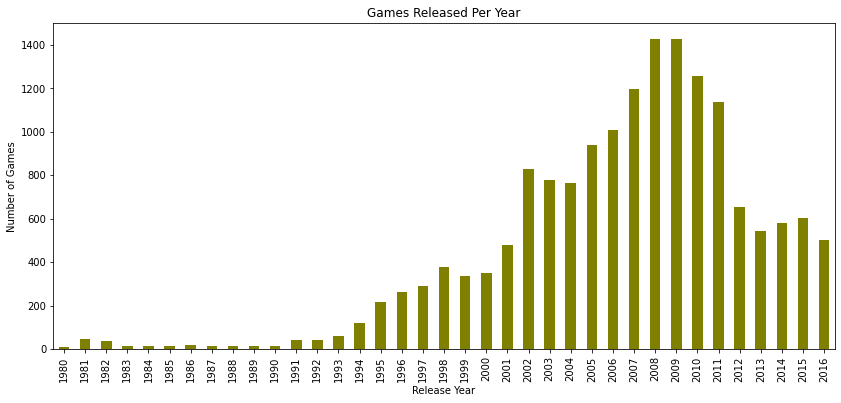

In [31]:
# plot number of games released per year
df.groupby('year_of_release')['name'].count().plot(kind = 'bar',
                                                   figsize=(14, 6),
                                                   color='olive',
                                                   xlabel='Release Year',
                                                   ylabel='Number of Games',
                                                   title='Games Released Per Year'
                                                  );

Every game in this dataset was released between 1980 and 2016. There are fewer older games in our dataset - the majority of our games are from 1991 and later.

In [32]:
# Viewing average year of release for each platform
df.pivot_table(index='platform', values='year_of_release', aggfunc='median').sort_values(by='year_of_release', ascending=False)

,year_of_release
platform,
XOne,2015.0
PS4,2015.0
PSV,2014.0
WiiU,2013.0
3DS,2013.0
PS3,2011.0
X360,2010.0
PC,2010.0
Wii,2009.0


In [33]:
# get top 5 platforms with the most sales
top_platforms = df.pivot_table(index = 'platform', 
               values = 'total_sales', 
               aggfunc = 'sum').sort_values(by='total_sales', 
                                            ascending=False).head()

top_platforms

,total_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79


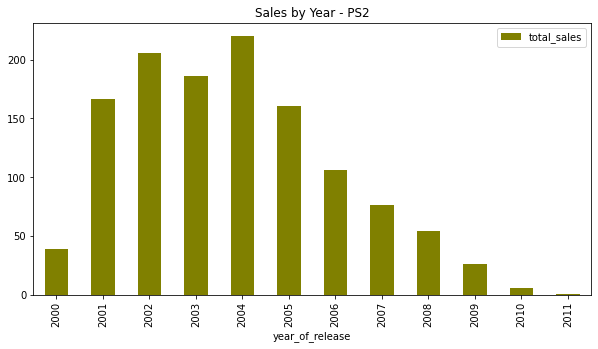

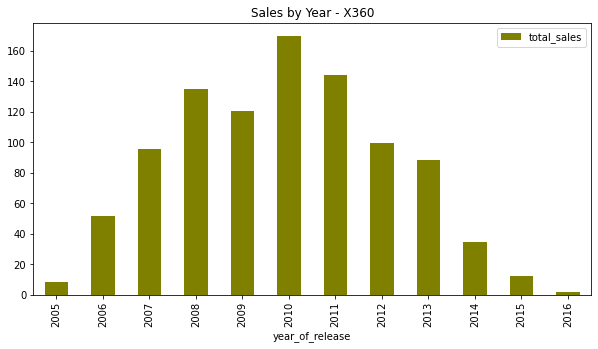

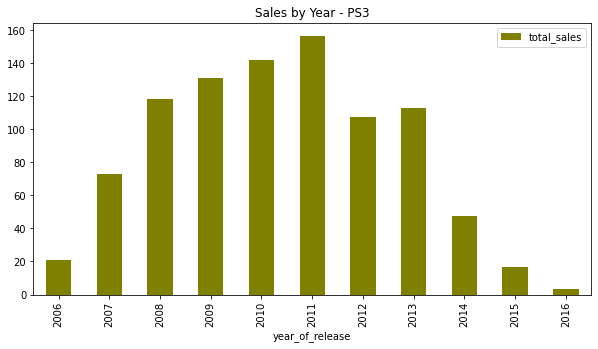

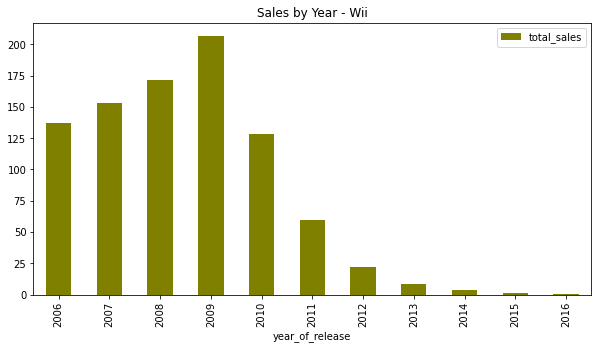

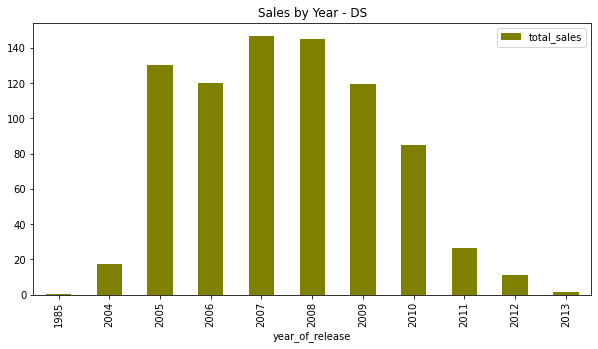

In [34]:
# create distributions by year of the top platforms
for platform in top_platforms.index:
    df.query('platform == @platform').pivot_table(index='year_of_release',
                                                 values='total_sales',
                                                 aggfunc='sum').plot(kind = 'bar',
                                                                    figsize = (10, 5),
                                                                    color = 'olive',
                                                                    title = f'Sales by Year - {platform}')

PS2s have the most sales of any platform in the database, but their sales peaked in 2004 and have not survived into the 2010s. For each each of the top flatforms, sales tend to peak 4-5 years after release. New platforms tend to only survive for 10 years max, likely due to new platforms appearing. For example, PS2's last game was in 2011, which is the same year that PS3 came out.

Though video game platforms tend to survive for 10 years, they really only peak for 4-5 years after they've been release. As such, we will only look at the data between 2011-2016; all prior years will be omitted from our analysis.

### Platforms

In [35]:
# filter out irrelevant data
df_filtered = df.query('year_of_release >= 2011').reset_index(drop=True)

# check data
df_filtered.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
2,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88,3.4,M,14.73
3,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,NA,14.63
4,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1,-1.0,NA,14.60


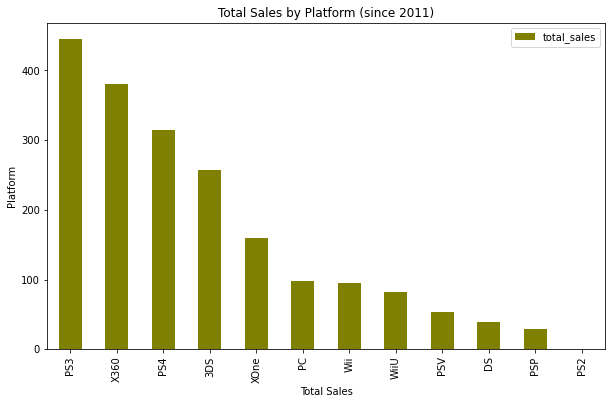

In [36]:
# Bar plot of leading platforms (by total sales)
df_filtered.pivot_table(index='platform',
                        values='total_sales',
                        aggfunc='sum').sort_values(by='total_sales', ascending=False).plot(kind = 'bar',
                                           figsize=(10, 6),
                                            color='olive',
                                            title='Total Sales by Platform (since 2011)',
                                            xlabel='Total Sales',
                                            ylabel='Platform'
                                           );

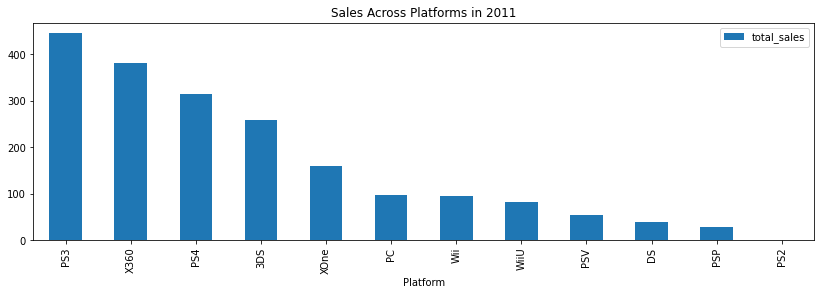

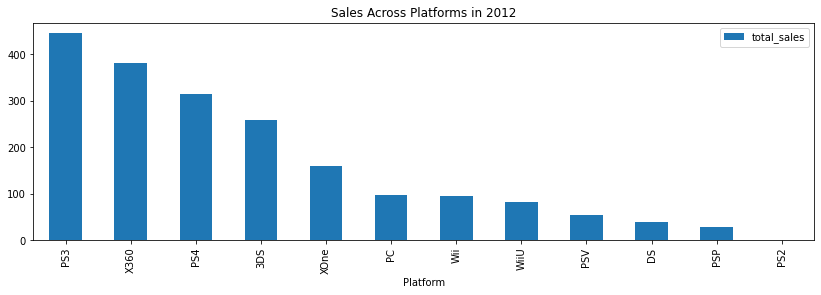

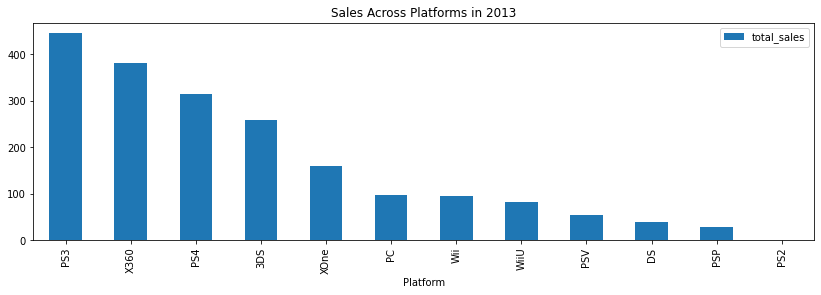

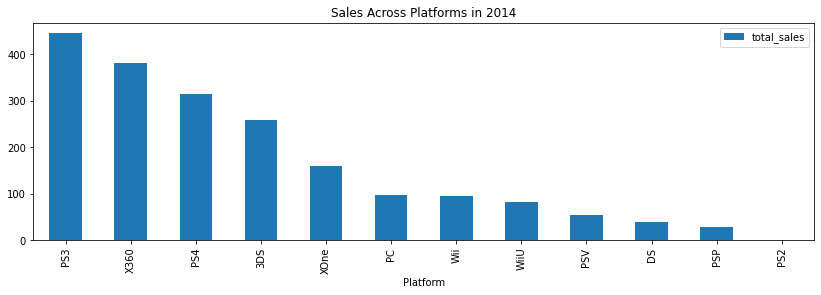

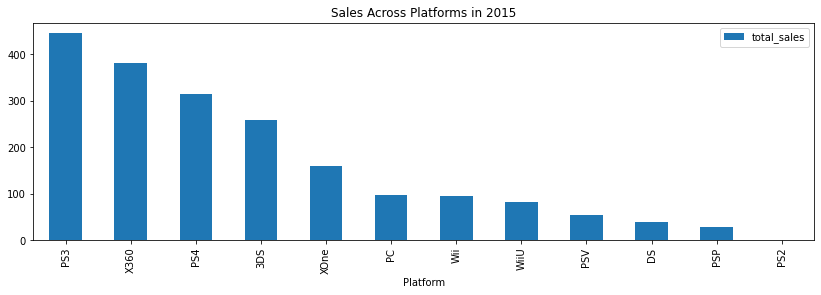

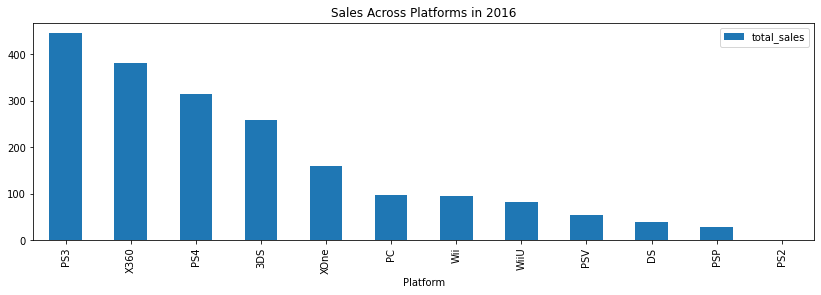

In [37]:
# Check platforms per year
years = [2011, 2012, 2013, 2014, 2015, 2016]

# Plot table for each year with the platforms being sold
for year in years:
    df_filtered.pivot_table(index='platform',
                              values='total_sales',
                              aggfunc='sum'
                             ).sort_values(by='total_sales',
                                           ascending=False).plot(kind='bar',
                                                                 figsize=(14,4),
                                                                 title=f'Sales Across Platforms in {year}',
                                                                 xlabel='Platform'
                                                                );

In [38]:
# Table view of platforms and release years
df_filtered.query('year_of_release >= 2011').pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')

year_of_release,2011,2012,2013,2014,2015,2016
platform,,,,,,
3DS,63.20,51.36,56.57,43.76,27.78,15.14
DS,26.18,11.01,1.54,NaN,NaN,NaN
PC,35.03,23.22,12.38,13.28,8.52,5.25
PS2,0.45,NaN,NaN,NaN,NaN,NaN
PS3,156.78,107.36,113.25,47.76,16.82,3.60
PS4,NaN,NaN,25.99,100.00,118.90,69.25
PSP,17.82,7.69,3.14,0.24,0.12,NaN
PSV,4.63,16.19,10.59,11.90,6.25,4.25
Wii,59.65,21.71,8.59,3.75,1.14,0.18


From these graphs and this table, we can more clearly view the platforms that are decreasing in popularity.

The WiiU, DS, PC, PS2, PSP, PSV, and Wii are obsolete - these platforms have been steadily declining over the years, either due to newer versions of their platforms being released or simply due to the platform not gaining popularity upon release (ie for the WiiU).

The PS3 and X360 topped the charts until 2014, when their newer versions (the PS4 and XOne) came out. As such, despite their initial popularity, the PS3 and X360 will likely continue to decline. 

The 3DS has the third highest amount of sales in 2016, but these sales have been declining over the years.

Of all the platforms given, the most profitable would be the PS4 and XOne.

### Global Sales

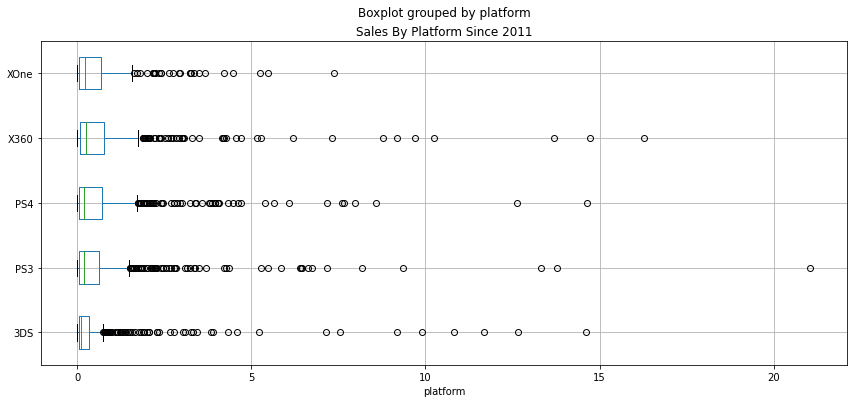

In [39]:
# only check relevant platforms 
platforms = ['PS4', 'PS3', 'XOne', 'X360', '3DS']

# plot sales since 2011 per platform
df_filtered.query('year_of_release >= 2011 and platform in @platforms').boxplot(column='total_sales',
                                                                                by='platform',
                                                                                figsize=(14,6),
                                                                                vert=False);
plt.title('Sales By Platform Since 2011');

From this graph, we can see that there are many games that are outliers in the number of sales they had, creating a large right skew in our graph. This makes sense - games that are extremely popular are less common.

Comparing XOne and X360 to PS4 and PS3, there's little difference in the data that falls between the first and third quartile ranges.

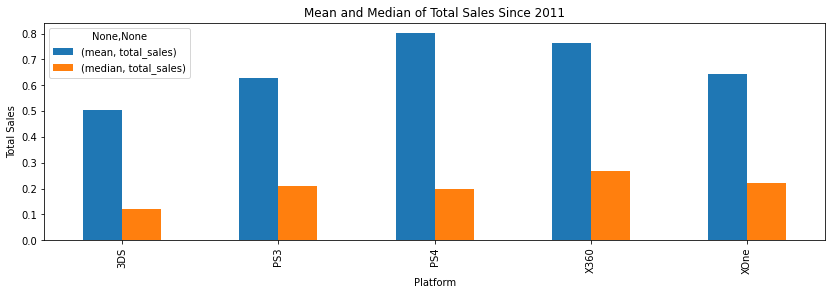

In [40]:
# print bar plots showing mean and median of total sales since 2011
df_filtered.query('year_of_release >= 2011 and platform in @platforms').pivot_table(index='platform',
                                                                                    values='total_sales',
                                                                                    aggfunc=['mean', 'median']).plot(kind='bar',
                                                                                                                     figsize=(14,4),
                                                                                                                     title='Mean and Median of Total Sales Since 2011',
                                                                                                                     xlabel='Platform',
                                                                                                                     ylabel='Total Sales'
                                                                                                                    );

Above, I plotted the mean versus the median for each platform since 2011. The mean is significantly higher than the medians, which we could tell from our right-skew. 

Though the PS4 has the highest mean total sales, it has a lower median of total sales than PS3, X360, and XOne, indicating that it had a few high performing games that sold many copies. However, the medians are fairly similar between PS3, PS4, X360, and XOne, with the Xbox platforms slightly outperforming PS3 and PS4.

### Reviews vs Total Sales

I will observe how user reviews and professional reviews (`user_score` and `critic_score`) affect the number of sales. First, I will filter out rows where either column have '-1' as the value. Then, I will compare reviews vs sales among the PS4 and XOne platforms.

In [41]:
# filter out rows without ratings
df_reviews = df_filtered.query('critic_score != -1 and user_score != -1').reset_index(drop=True)

# print head
df_reviews.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
2,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88,3.4,M,14.73
3,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83,5.3,M,13.79
4,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83,4.8,M,13.68


For each platform, I will create two scatteplots: One illustrating the relationship between Total Sales and User Score, and one illustrating the relationship between Total Sales and Critic Score.

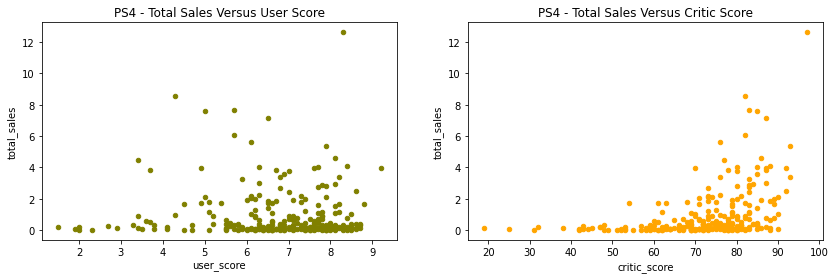

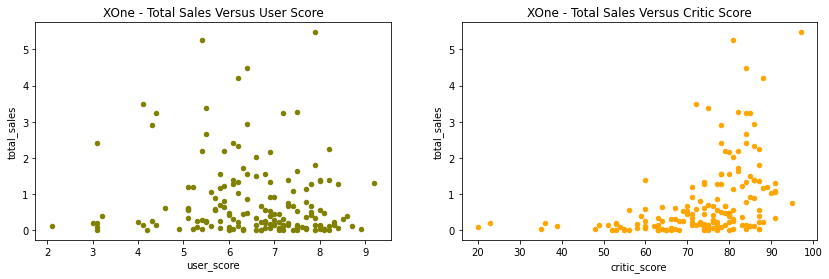

In [42]:
for platform in ['PS4', 'XOne']:
    fig, ax = plt.subplots(ncols=2, figsize=(14,4))
    platform_df = df_reviews.query('platform == @platform')
    platform_df.plot.scatter(x = 'user_score',
                             y = 'total_sales',
                             title = f'{platform} - Total Sales Versus User Score',
                             color = 'olive',
                             ax=ax[0]);
    platform_df.plot.scatter(x = 'critic_score',
                             y = 'total_sales',
                             title = f'{platform} - Total Sales Versus Critic Score',
                             color = 'orange', ax=ax[1]);

In [43]:
# correlation matrix for XOne Platform
df_reviews.query('platform == "XOne"')[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.410422
user_score,0.472462,1.000000,-0.094003
total_sales,0.410422,-0.094003,1.000000


In [44]:
# correlation matrix for PS4 Platform
df_reviews.query('platform == "PS4"')[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.405895
user_score,0.557654,1.000000,-0.033625
total_sales,0.405895,-0.033625,1.000000


Comparing `critic_score` with `total_sales` and `user_score` with `total_sales` for both platforms, there is not a strong correlation for either. 

In both platforms, correlation between `user_score` and `total_sales` is very close to 0. Additionally, both platforms have an approximate correlation of 0.41 between `total_sales` and `critic_score` - this is still not a strong correlation, as indicated by our graphs.

### Genres

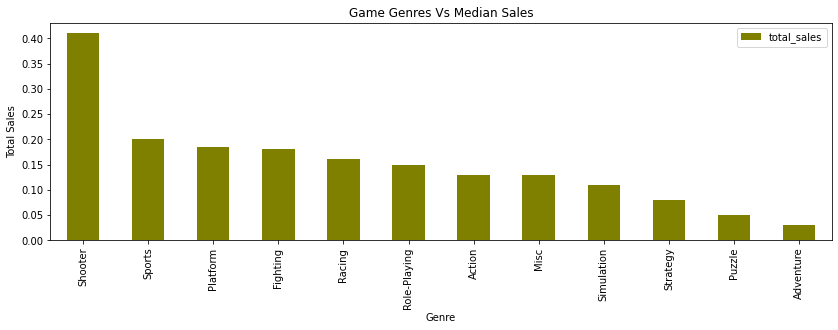

In [45]:
# plot bar graph showing the most popular genres based on mean total sales
df_filtered.pivot_table(index='genre',
                        values='total_sales',
                        aggfunc='median').sort_values(by = 'total_sales',
                                                   ascending=False).plot(kind='bar',
                                                                    title='Game Genres Vs Median Sales',
                                                                    xlabel='Genre',
                                                                    ylabel='Total Sales',
                                                                    figsize=(14,4),
                                                                    color='olive'
                                                                    );

The above graph shows the most profitable video game genres based on the median number of sales. Since 2011, we can see that Shooter games tend to have the greatest median sales.

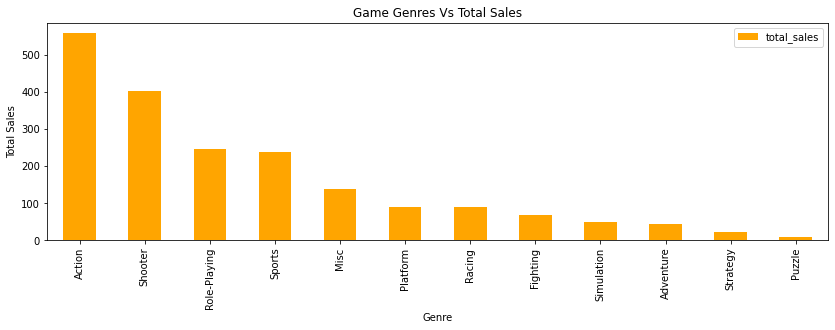

In [46]:
# plot bar graph showing the most popular genres based on mean total sales
df_filtered.pivot_table(index='genre',
                        values='total_sales',
                        aggfunc='sum').sort_values(by = 'total_sales',
                                                   ascending=False).plot(kind='bar',
                                                                    title='Game Genres Vs Total Sales',
                                                                    xlabel='Genre',
                                                                    ylabel='Total Sales',
                                                                    figsize=(14,4),
                                                                    color='orange'
                                                                    );

In terms of total sales, games that fall under the action, shooter, role-playing, or sports categories have the most sales since 2011, meaning that the most profitable individual games appear within these four categories. 

In both graphs, adventure games, puzzle games, and strategy games fall at the tail end of sales. Action, shooter, and sports games can be considered our most profitable genres between both graphs.

### Regions

So far, I have been observing global sales regardless of region, but next I will check how top genres, platforms, and ESRB ratings vary across North America, Europe, and Japan.

In [47]:
# list of regions to loop through
regions = ['na_sales', 'eu_sales', 'jp_sales']

# get tables for platforms, genres, and ratings (filtering out unpresent ratings)
platform_table = df_filtered.pivot_table(index='platform', values=regions, aggfunc='sum')
genre_table = df_filtered.pivot_table(index='genre', values=regions, aggfunc='sum')
rating_table = df_filtered.pivot_table(index='rating', values=regions, aggfunc='sum').query('rating != "NA"')

#### Platforms By Region

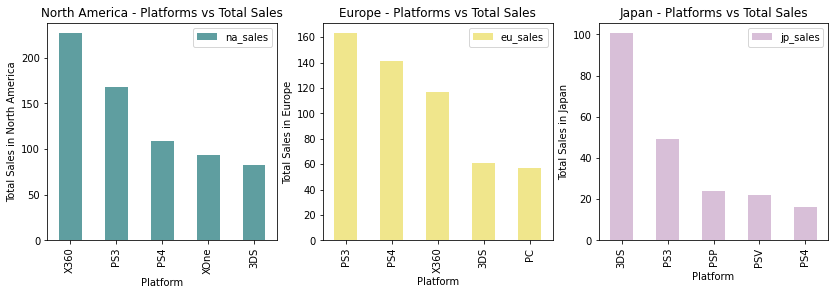

In [48]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

# plot top five platforms in north america
platform_table[[regions[0]]].sort_values(by=regions[0], ascending=False).head(5).plot(kind='bar', title='North America - Platforms vs Total Sales', xlabel='Platform', ylabel='Total Sales in North America', color='cadetblue', ax=ax[0]);

# plot top five platforms in europe
platform_table[[regions[1]]].sort_values(by=regions[1], ascending=False).head(5).plot(kind='bar', title='Europe - Platforms vs Total Sales', xlabel='Platform', ylabel='Total Sales in Europe', color='khaki', ax=ax[1]);

# plot top five platforms in japan
platform_table[[regions[2]]].sort_values(by=regions[2], ascending=False).head(5).plot(kind='bar', title='Japan - Platforms vs Total Sales', xlabel='Platform', ylabel='Total Sales in Japan', color='thistle', ax=ax[2]);

The three bar graphs above show the top five platforms per region. The top platform is different since 2011 for all three regions - X360 for North AMerica, PS3 for Europe, and the 3DS for Japan. The PS3, PS4, and 3DS show up in all three graphs, but the X360 does not show up in Japan's top 5 platforms.

North America also has more sales overall than Europe or Japan do individually, with over double the amount of sales for its top platform (X360) when compared to Japan's top platform (3DS).

#### Genres By Region

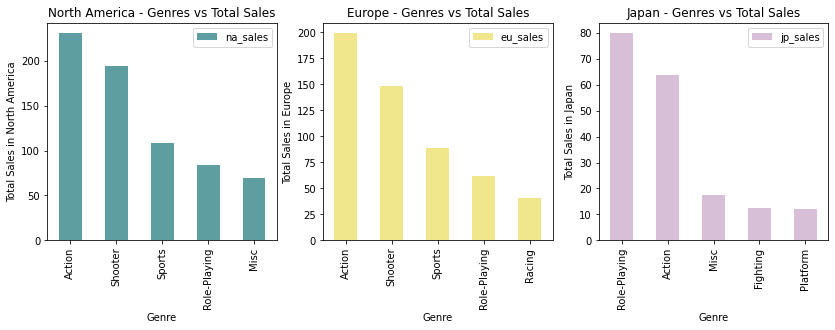

In [49]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

# plot top five platforms in north america
genre_table[[regions[0]]].sort_values(by=regions[0], ascending=False).head(5).plot(kind='bar', title='North America - Genres vs Total Sales', xlabel='Genre', ylabel='Total Sales in North America', color='cadetblue', ax=ax[0]);

# plot top five platforms in europe
genre_table[[regions[1]]].sort_values(by=regions[1], ascending=False).head(5).plot(kind='bar', title='Europe - Genres vs Total Sales', xlabel='Genre', ylabel='Total Sales in Europe', color='khaki', ax=ax[1]);

# plot top five platforms in japan
genre_table[[regions[2]]].sort_values(by=regions[2], ascending=False).head(5).plot(kind='bar', title='Japan - Genres vs Total Sales', xlabel='Genre', ylabel='Total Sales in Japan', color='thistle', ax=ax[2]);

Genres are fairly similar across North America and Europe, sharing similar amount of sales for their top four genres (Action, Shooter, Sports, and Role-Playing). In contrast, Role-Playing is Japan's top genre, with Action being #2.

#### Ratings

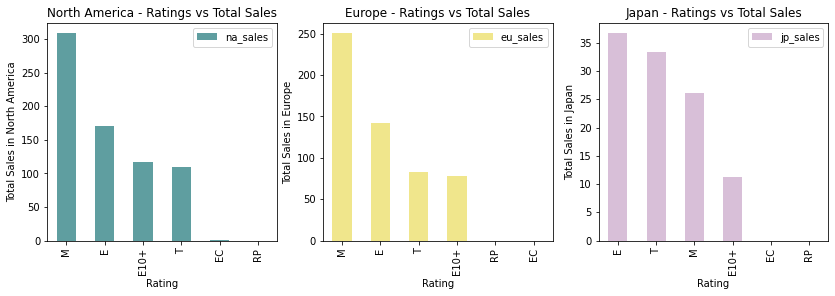

In [50]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

# plot top five platforms in north america
rating_table[[regions[0]]].sort_values(by=regions[0], ascending=False).plot(kind='bar', title='North America - Ratings vs Total Sales', xlabel='Rating', ylabel='Total Sales in North America', color='cadetblue', ax=ax[0]);

# plot top five platforms in europe
rating_table[[regions[1]]].sort_values(by=regions[1], ascending=False).plot(kind='bar', title='Europe - Ratings vs Total Sales', xlabel='Rating', ylabel='Total Sales in Europe', color='khaki', ax=ax[1]);

# plot top five platforms in japan
rating_table[[regions[2]]].sort_values(by=regions[2], ascending=False).plot(kind='bar', title='Japan - Ratings vs Total Sales', xlabel='Rating', ylabel='Total Sales in Japan', color='thistle', ax=ax[2]);

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
    
Pro tip: also it may be useful to add category "other platforms" and plot unrated games (we have 50% unrated games).
</div>

For these graphs, "NA" ratings were filtered out so that we are only looking at games that have valid ratings. Similar to their genre profiles, North America and Europe share a similar trend. Games rated M, followed by E, have the greatest amount of sales. For both regions, T and E10+ have similar amounts of sales.

Japan, like its genre profile, is different from the other two regions. Games rated E and T have the greatest amount og sells, followed by M. Unlike the other two regions, these three ratings are closer in number of sales than the top three in the other two regions.

By creating these region profiles, I was able to observe trends in platforms, genres, and ratings when compared to total sales across North America, Europe, and Japan. North America and Europe share similar qualities, especially when it comes to genre and rating trends, whereas Japan's profile is different. As such, games that do well in Japan may not due as well in North America and Europe (and vice versa).

## Hypothesis Testing

### User Ratings: Xbox One and PC Platforms

I will conduct hypothesis testing. First, I will see if user ratings are the same between the Xbox One and PC platforms. 

The null hypothesis is that the average user rating is the same between Xbox One and PC, and the alternative hypothesis is that the average user rating is different.

As is standard, 0.05 will be used as the alpha value.

In [51]:
# create dataframes for xbox one and pc platforms
xone_df = df_filtered.query('platform == "XOne" and user_score != -1')
pc_df = df_filtered.query('platform == "PC" and user_score != -1')

In [52]:
# check variances
print(f'Xbox One - User Ratings Variance: {xone_df.user_score.var()}')
print(f'PC - User Ratings Variance: {pc_df.user_score.var()}')

Xbox One - User Ratings Variance: 1.9069968429360695
PC - User Ratings Variance: 2.5962957995358837


In [53]:
# test the hypotheses - variances are similar
results = st.ttest_ind(xone_df['user_score'], pc_df['user_score'], equal_var = True)
print(f'p-value: {results.pvalue}')

p-value: 0.6267602271422398


Our p_value of 0.63 is greater than our alpha value of 0.05, so we cannot reject the null hypothesis. This means that we cannot say that the average user rating is different between the Xbox One and PC platforms.

### User Ratings: Action and Sports Genres

Next, I will compare the Action and Sports genres and see if the average user rating is the same between these genres.

The null hypothesis is that the average user rating is the same for action games and sports games. The alternative hypothesis is that the average user ratings are difference for these two genres.

Like before, the alpha value will be 0.05.

In [54]:
# create dataframes for action and sports genres
action_df = df_filtered.query('genre == "Action" and user_score != -1')
sports_df = df_filtered.query('genre == "Sports" and user_score != -1')

In [55]:
# check variances
print(f'Action - User Ratings Variance: {action_df.user_score.var()}')
print(f'Sports - User Ratings Variance: {sports_df.user_score.var()}')

Action - User Ratings Variance: 1.8118770103036579
Sports - User Ratings Variance: 2.8825095404015264


In [56]:
# test the hypotheses - variances are similar
results = st.ttest_ind(action_df['user_score'], sports_df['user_score'], equal_var = True)
print(f'p-value: {results.pvalue}')

p-value: 5.1974550252152054e-24


Our p-value is much smaller than our alpha value of 0.05, so our p-value is statistically significant. We can reject our null hypothesis and say that the average user rating of sport games is not the same as the average user rating of action games.

## Conclusion

The goal of this analysis was to determine what causes a game to succeed once it is released. For this analysis, games released after 2011 were observed. Globally, the most popular platforms were the PS4, PS3, XOne, X360, and 3DS, but some platforms (ie the PS3 and X360) were declining in sales due to newer systems (the PS4 and XOne) being released. The 3DS is declining in sales but has the greatest number of total sales in Japan. 

I also observed genres, both globally and regionally, and found that of all genres, Action games are the most popular. Some genres, like Puzzles or Strategy, have significantly less success. A game's rating seems to affect the total sales of a game, with games rated M and E being the most popular, excluding in Japan (where the most popular rating is E, followed by T).

Hypothesis testing was conducting to see if the average user rating is the same for two platforms (Xbox One and PC) and two genres (Action and Sports). The average user rating was found to be different for the genres, but not the ratings. In the future, additional analysis can be conducted for other genres and platforms (ie the ones we found to be correlated with higher sales).

The popularity of a game in 2017 will be affected by its rating, genre, and platform, and its total sales may vary regionally. Because North America and Europe have the greatest amount of sales, it would be beneficial to target those regions with an Xbox One or PS4 Action game.